#mobilenet-Image classification

In [ ]:
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten , Conv2D, MaxPool2D, Input
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import shutil
import random
import tensorflow_hub as hub
import os

In [ ]:
print(tf.__version__)

2.17.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
Train_DIR = "/content/drive/MyDrive/Colab Notebooks/project/food_datasets_cv/meta/meta/train.txt"
Test_DIR = "/content/drive/MyDrive/Colab Notebooks/project/food_datasets_cv/meta/meta/test.txt"
image_DIR = "/content/drive/MyDrive/Colab Notebooks/project/food_datasets_cv/images"
label_DIR = "/content/drive/MyDrive/Colab Notebooks/project/food_datasets_cv/meta/meta/labels.txt"
classes_DIR = "/content/drive/MyDrive/Colab Notebooks/project/food_datasets_cv/meta/meta/classes.txt"
train_json = "/content/drive/MyDrive/Colab Notebooks/project/food_datasets_cv/meta/meta/train.json"
test_json = "/content/drive/MyDrive/Colab Notebooks/project/food_datasets_cv/meta/meta/test.json"

### Split image

In [ ]:
# Data Augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# training set with data autmentation
train_ds = train_datagen.flow_from_directory(
    directory=image_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# validate set without Data Augmentation
val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

val_ds = val_datagen.flow_from_directory(
    directory=image_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42,
    subset="validation"
)

Found 101000 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [ ]:
classes = []
with open(classes_DIR) as f:
    for line in f.readlines():
        classes.append(line.split("\n")[0])

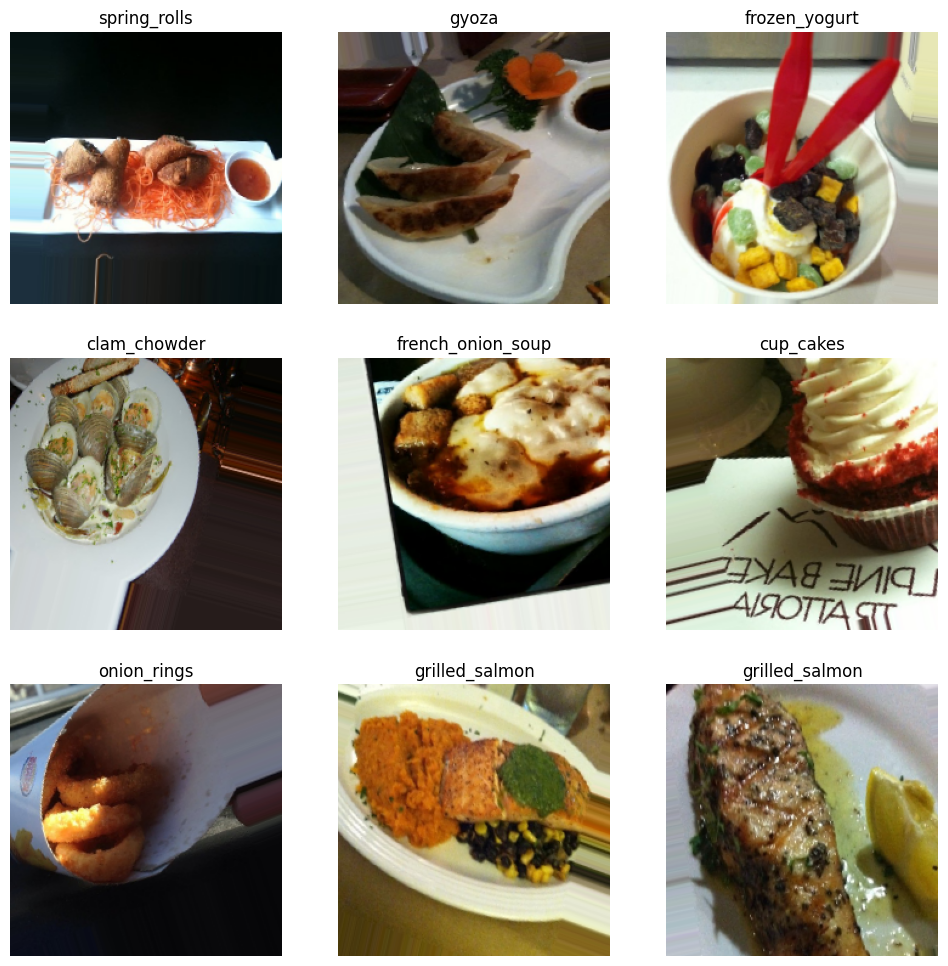

In [ ]:
num_images = 9

images, labels = next(train_ds)

plt.figure(figsize=(12, 12))

for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    class_name = classes[np.argmax(labels[i])]
    plt.title(class_name)
    plt.axis("off")

plt.show()

### Modeling

In [ ]:
#Defining CallBack list
from tensorflow.keras import callbacks
callback_list=[
    callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.8,monitor="val_accuracy",patience=3)
]

In [ ]:
width = 224
num_classes = 101

In [ ]:
from tensorflow.keras.models import Model

input_layer = Input(shape=(width, width, 3))
base = MobileNetV2(input_shape=(width,width,3), include_top=False, weights='imagenet')
base.trainable = True


x = base(input_layer, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=input_layer, outputs=output_layer)


opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 101)                 │          13,029 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,434,981 (9.29 MB)

 Trainable params: 2,400,869 (9.16 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# Fitting the model for 10 epochs
Model_1_History = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=callback_list
)

Epoch 1/10
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 1434s 441ms/step - accuracy: 0.0732 - loss: 4.1620 - val_accuracy: 0.0826 - val_loss: 7.3193 - learning_rate: 0.0010
Epoch 2/10
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 1377s 435ms/step - accuracy: 0.2626 - loss: 2.9917 - val_accuracy: 0.2140 - val_loss: 4.4980 - learning_rate: 0.0010
Epoch 3/10
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 1376s 435ms/step - accuracy: 0.3650 - loss: 2.5487 - val_accuracy: 0.3409 - val_loss: 3.1847 - learning_rate: 0.0010
Epoch 4/10
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 1370s 433ms/step - accuracy: 0.4253 - loss: 2.3021 - val_accuracy: 0.3445 - val_loss: 3.2432 - learning_rate: 0.0010
Epoch 5/10
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 1368s 432ms/step - accuracy: 0.4723 - loss: 2.1124 - val_accuracy: 0.3507 - val_loss: 3.2844 - learning_rate: 0.0010
Epoch 6/10
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 1372s 434ms/step - accuracy: 0.5077 - loss: 1.9676 - val_accuracy: 0.3987 - val_loss: 2.7033 - learning_rate: 0.0010
Epoch 7/10
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 1369

In [ ]:
#Define the function to plot loss and accuracy curves of train - valid
def plot_loss_curves(history):
    train_loss = history.history["loss"]
    val_loss = history.history['val_loss']
    train_accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    #Plot Loss
    plt.plot(epochs , train_loss , label = "Train Loss")
    plt.plot(epochs , val_loss , label = "Val Loss" )
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()
    #Plot accuracy
    plt.figure()
    plt.plot(epochs ,train_accuracy , label = "train_accuracy")
    plt.plot(epochs , val_accuracy , label = "val_accuracy" )
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

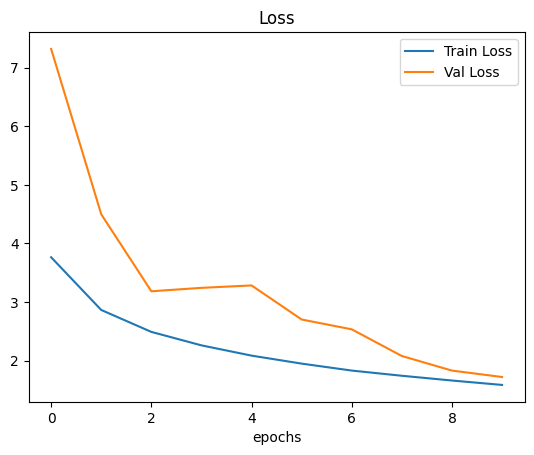

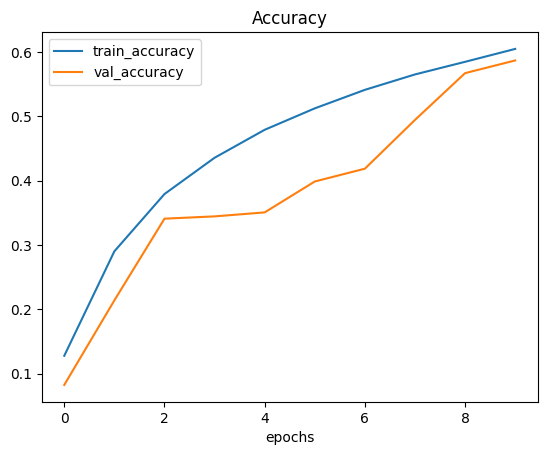

In [ ]:
plot_loss_curves(Model_1_History)

In [ ]:
Model_1_History_continued = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    initial_epoch=10,
    verbose=1,
    callbacks=callback_list
)

Epoch 11/20
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 1386s 438ms/step - accuracy: 0.6175 - loss: 1.5382 - val_accuracy: 0.6137 - val_loss: 1.5748 - learning_rate: 0.0010
Epoch 12/20
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 1388s 439ms/step - accuracy: 0.6298 - loss: 1.4733 - val_accuracy: 0.5045 - val_loss: 2.1942 - learning_rate: 0.0010
Epoch 13/20
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 1375s 435ms/step - accuracy: 0.6444 - loss: 1.4181 - val_accuracy: 0.5670 - val_loss: 1.8503 - learning_rate: 0.0010
Epoch 14/20
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 1372s 434ms/step - accuracy: 0.6538 - loss: 1.3761 - val_accuracy: 0.6289 - val_loss: 1.4871 - learning_rate: 0.0010
Epoch 15/20
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 1375s 435ms/step - accuracy: 0.6705 - loss: 1.3174 - val_accuracy: 0.6271 - val_loss: 1.4861 - learning_rate: 0.0010
Epoch 16/20
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 1380s 436ms/step - accuracy: 0.6742 - loss: 1.2895 - val_accuracy: 0.6538 - val_loss: 1.3959 - learning_rate: 0.0010
Epoch 17/20
3157/3157 ━━━━━━━━━━━━━━━━━━

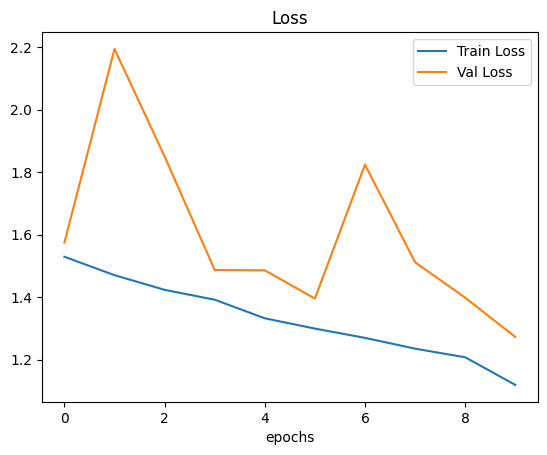

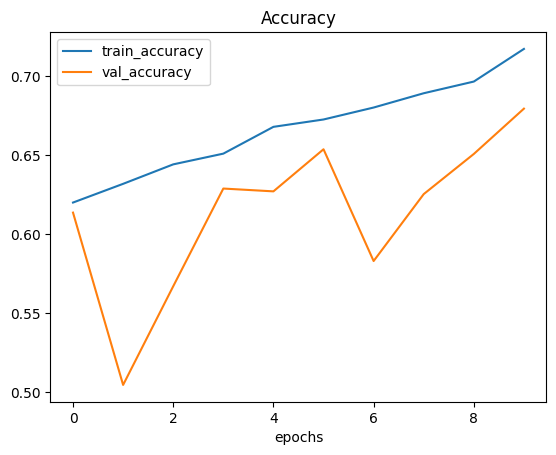

In [ ]:
plot_loss_curves(Model_1_History_continued)

### Testing image

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


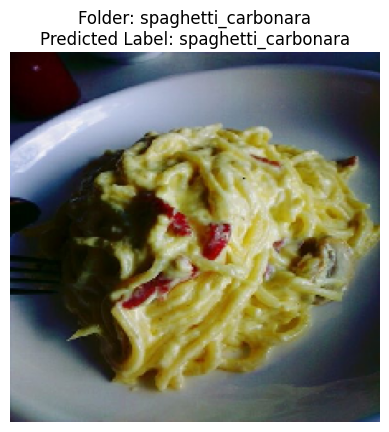

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


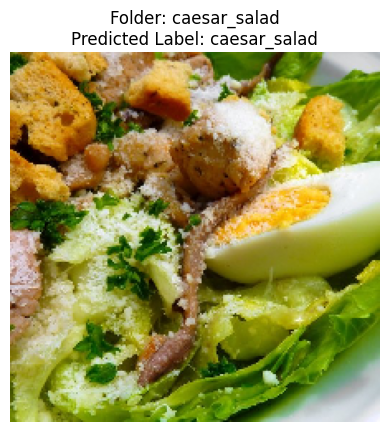

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


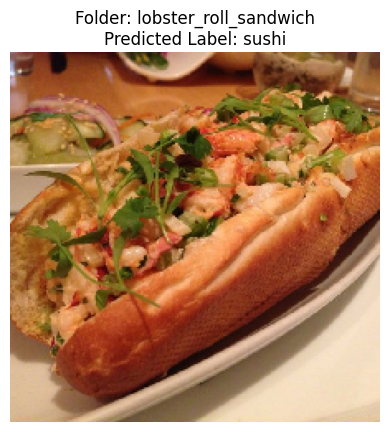

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


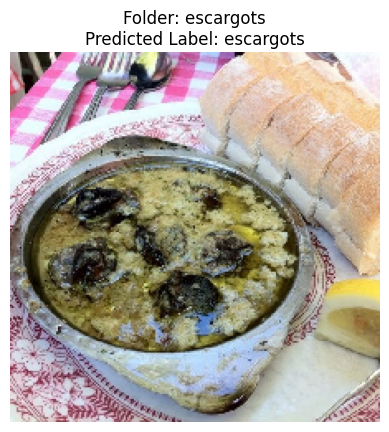

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


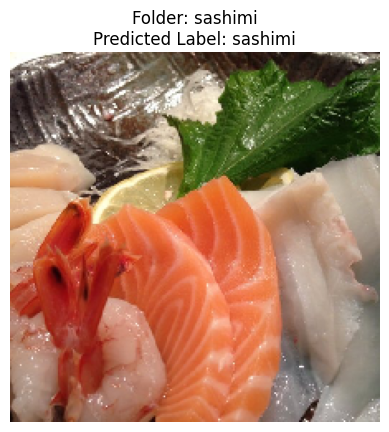

In [ ]:
import random
from tensorflow.keras.preprocessing import image

class_file_path = classes_DIR
test_image_folder = image_DIR

with open(class_file_path, 'r') as file:
    class_names = [line.strip() for line in file.readlines()]


def load_and_prepare_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img, img_array

# random 5 pics
random_folders = random.sample(os.listdir(test_image_folder), 5)


for folder_name in random_folders:
    folder_path = os.path.join(test_image_folder, folder_name)

    # select 1 pic for each folder
    random_image = random.choice(os.listdir(folder_path))
    img_path = os.path.join(folder_path, random_image)

    # load pic
    img, img_array = load_and_prepare_image(img_path)

    # prediction label
    prediction = model.predict(img_array)
    predicted_label = np.argmax(prediction, axis=1)[0]

    # compare label with class.txt
    predicted_label_name = class_names[predicted_label]


    plt.imshow(img)
    plt.title(f'Folder: {folder_name}\nPredicted Label: {predicted_label_name}')
    plt.axis('off')
    plt.show()



---



---

Save model

In [ ]:
model.save('mobilenetv2_model_5.h5')

In [ ]:
model.save('mobilenetv2_model_5.keras')